In [7]:
"""
Adapted from Track1/find.py
"""
import argparse
from pathlib import Path
import os
import sys

In [37]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

In [ ]:
print(HERE)
sys.path.insert(0, str(Path(HERE, '..')))  # kinship root
sys.path.insert(0, str(Path(HERE, '..', 'rfiw2021')))  # rfiw2021 dir

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.manifold import TSNE

In [22]:
from dataset import FIW
from Track1.losses import contrastive_loss
from Track1.models import Net
from Track1.utils import set_seed

In [23]:
def extract_embeddings(val_loader, model):
    embeddings = []
    labels = []

    for img, family_id in tqdm(val_loader):
        with torch.no_grad():
            embeddings.append(model.encoder(img.cuda()).cpu().numpy())
            labels.append(family_id)

    # Now, embeddings contain all the embeddings from your model
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

In [30]:
def plot_embeddings(embeddings, labels, plot_path):

    # Create a color map for families
    color_map = {250: "red", 283: "blue", 409: "green", 735: "purple", 873: "orange"}
    
    # Prepare a figure to hold the subplots
    fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the axes array to make it easier to work with

    # Generate and plot t-SNE for different perplexity values
    for i, perplexity in enumerate(range(10, 101, 10)):
        print(f"Generating t-SNE with perplexity={perplexity}")
        tsne = TSNE(n_components=2, perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(embeddings)

        ax = axes[i]  # Get the current subplot

        # Plot
        for label, color in color_map.items():
            idxs = [idx for idx, val in enumerate(labels) if val == str(label)]
            ax.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], color=color, label=f"Family #0{label}")

        ax.set_title(f"Perplexity: {perplexity}")
        ax.legend()

    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path)
    plt.show()

In [33]:
def run(root_dir, batch_size, save_path, plot_path: str = ''):
    # Loading and sampling the dataset
    val_dataset = FIW(root_dir=root_dir, families=[250, 283, 409, 735, 873])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False)

    # Loading model
    model = Net().cuda()
    model.load_state_dict(torch.load(save_path))
    model.eval()

    set_seed(100)

    # Extracting embeddings
    embeddings, labels = extract_embeddings(val_loader, model)

    # Plotting
    plot_embeddings(embeddings, labels, plot_path)

In [26]:
def parser():
    parser = argparse.ArgumentParser(description="plot embeddings")
    parser.add_argument("--root_dir", type=str, help="root directory of dataset")
    parser.add_argument("--save_path", type=str, help="model save path")
    parser.add_argument("--plot_path", type=str, help="plot save path")
    parser.add_argument("--batch_size", type=int, default=40, help="batch size default 40")
    parser.add_argument("--gpu", default="1", type=str, help="gpu id you use")
    args = parser.parse_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    run(**var(args))

  0%|                                                                                                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]/home/warley/.virtualenvs/rfiw2021/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


Generating t-SNE with perplexity=10
Generating t-SNE with perplexity=20
Generating t-SNE with perplexity=30
Generating t-SNE with perplexity=40
Generating t-SNE with perplexity=50
Generating t-SNE with perplexity=60
Generating t-SNE with perplexity=70
Generating t-SNE with perplexity=80
Generating t-SNE with perplexity=90
Generating t-SNE with perplexity=100


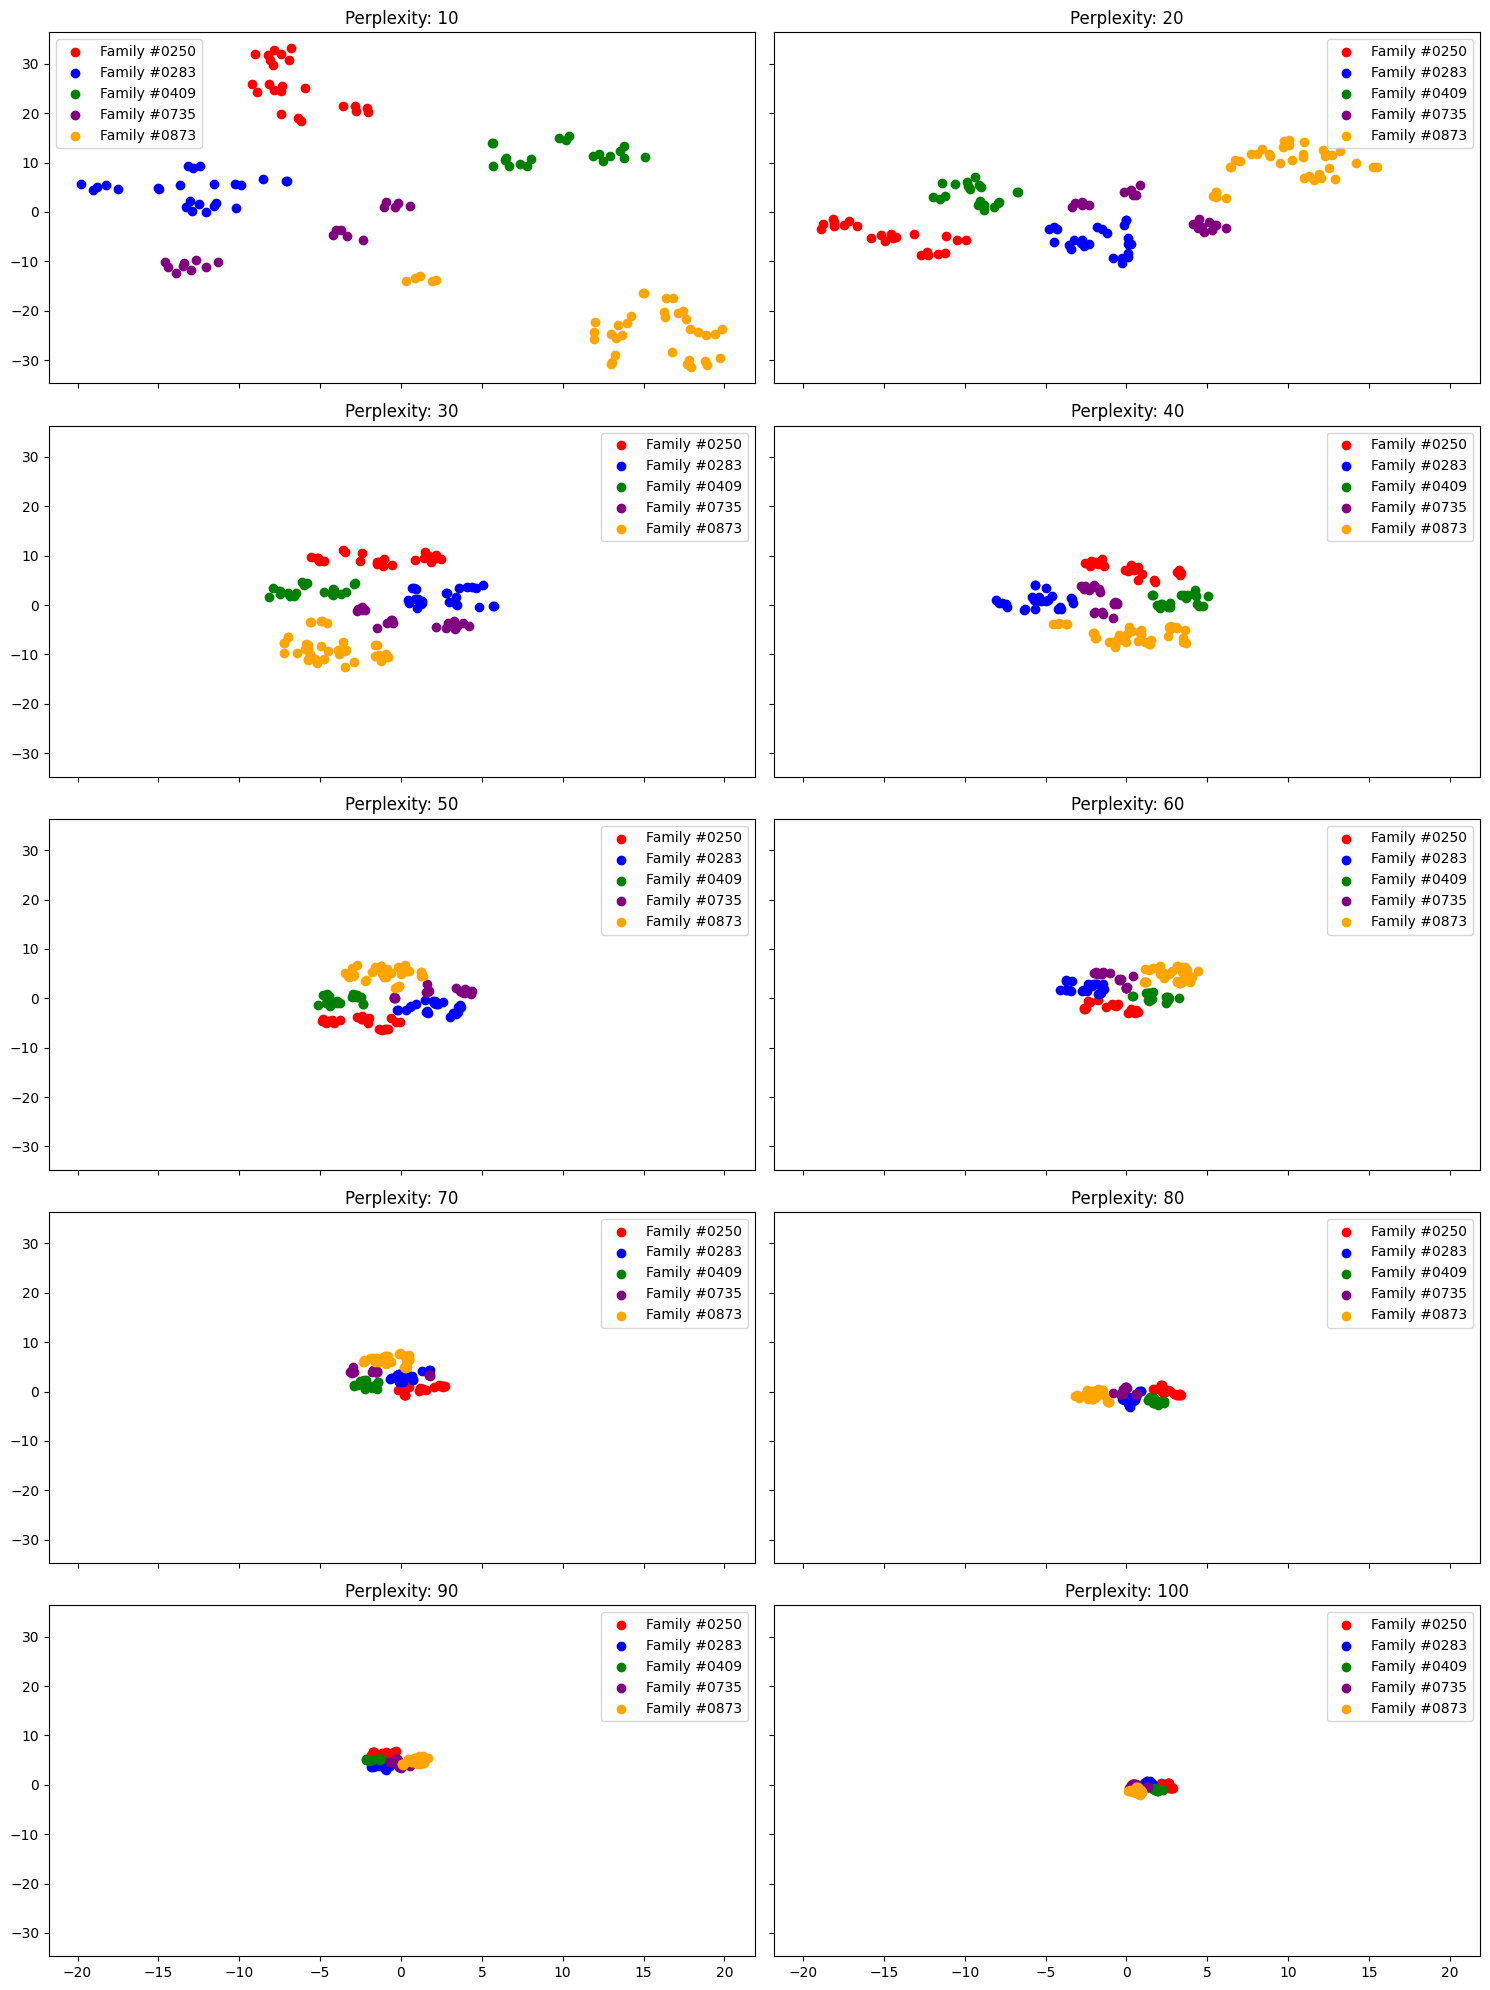

In [38]:
if IS_NOTEBOOK:
    if __name__ == "__main__":
        parser()
else:
    root_dir = Path(HERE, '../rfiw2021/Track1/Validation/val-faces')
    batch_size = 40
    save_path = Path(HERE, '../rfiw2021/Track1/model_track1.pth')
    plot_path = ''
    run(root_dir, batch_size, save_path)